In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchcsprng==0.1.3+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1.6MB 31.0MB/s 


In [ ]:
!pip install opacus

     |████████████████████████████████| 92kB 6.1MB/s 


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional
import os
import opacus
from opacus import PrivacyEngine
from collections import OrderedDict

In [ ]:
# __all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
#            'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
#            'wide_resnet50_2', 'wide_resnet101_2']


# model_urls = {
#     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
#     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
#     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
#     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
#     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
#     'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
#     'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
#     'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
#     'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
# }

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, k, kernel_size = 5, stride = 1):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels*k, kernel_size, stride)
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size = 2)
    
    def forward(self, x):
        x = self.conv(x)
        out = self.pool(self.tanh(x))
        
        return out 

### Vanilla LeNet

In [ ]:
# class LeNet5(nn.Module):

#     def __init__(self, n_classes):
#         super(LeNet5, self).__init__()
        
#         self.feature_extractor = nn.Sequential( OrderedDict([          
#             ("conv1", nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)),
#             ("tanh1", nn.Tanh()),
#             ("pool1", nn.AvgPool2d(kernel_size=2)),
#             ("conv2", nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)),
#             ("tanh2", nn.Tanh()),
#             ("pool1", nn.AvgPool2d(kernel_size=2)),
#             ("conv3", nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)),
#             ("tanh3", nn.Tanh())
#         ]))

#         self.classifier = nn.Sequential(OrderedDict([
#             ("fc1", nn.Linear(in_features=120, out_features=84)),
#             ("tanh4", nn.Tanh()),
#             ("fc2", nn.Linear(in_features=84, out_features=n_classes))
#         ]))


#     def forward(self, x):
#         x = self.feature_extractor(x)
#         x = torch.flatten(x, 1)
#         logits = self.classifier(x)
#         return logits

In [ ]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=4, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=4, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [ ]:
from torchsummary import summary
model = LeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_LeNet5.pth')
# model.load_state_dict(x['model'])
model.cuda()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 25, 25]             102
              Tanh-2            [-1, 6, 25, 25]               0
         AvgPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 9, 9]           1,552
              Tanh-5             [-1, 16, 9, 9]               0
         AvgPool2d-6             [-1, 16, 4, 4]               0
            Conv2d-7            [-1, 120, 1, 1]          30,840
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 43,508
Trainable params: 43,508
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [ ]:
model

LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(1, 6, kernel_size=(4, 4), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(4, 4), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(4, 4), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Wide LeNet with Linear Bottle Neck

In [ ]:
class Linear_WideLeNet5(nn.Module):

    def __init__(self, n_classes):
        super(Linear_WideLeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding = 1),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding = 1),
            nn.Conv2d(in_channels=8, out_channels=62, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=62, out_channels=11, kernel_size=1, stride=1, padding = 0),
            nn.Conv2d(in_channels=11, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        logits = self.classifier(x)
        return logits

In [ ]:
from torchsummary import summary
Linear_WideLeNet5 = Linear_WideLeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_L_LeNet5.pth')
# Linear_WideLeNet5.load_state_dict(x['model'])
Linear_WideLeNet5.cuda()
summary(Linear_WideLeNet5, (1, 28, 28))

RuntimeError: ignored

In [ ]:
Linear_WideLeNet5

Linear_WideLeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (5): Conv2d(8, 62, kernel_size=(5, 5), stride=(1, 1))
    (6): Tanh()
    (7): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (8): Conv2d(62, 11, kernel_size=(1, 1), stride=(1, 1))
    (9): Conv2d(11, 120, kernel_size=(5, 5), stride=(1, 1))
    (10): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Wide LeNet with Non-Linear Bottle Neck

In [ ]:
class Non_Linear_WideLeNet5(nn.Module):

    def __init__(self, n_classes):
        super(Non_Linear_WideLeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=32, kernel_size=5, stride=1, padding = 1),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=1, stride=1, padding = 1),
            nn.Tanh(),
            nn.Conv2d(in_channels=8, out_channels=62, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=62, out_channels=11, kernel_size=1, stride=1, padding = 0),
            nn.Tanh(),
            nn.Conv2d(in_channels=11, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        # print(x.shape)
        logits = self.classifier(x)
        return logits

In [ ]:
from torchsummary import summary
Non_Linear_WideLeNet5 = Non_Linear_WideLeNet5(10)
# x = torch.load('/content/drive/My Drive/checkpoint/ckpt_NL_LeNet5.pth')
# Non_Linear_WideLeNet5.load_state_dict(x['model'])
Non_Linear_WideLeNet5.cuda()
summary(Non_Linear_WideLeNet5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,832
              Tanh-5           [-1, 32, 12, 12]               0
            Conv2d-6            [-1, 8, 14, 14]             264
              Tanh-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 62, 10, 10]          12,462
              Tanh-9           [-1, 62, 10, 10]               0
        AvgPool2d-10             [-1, 62, 5, 5]               0
           Conv2d-11             [-1, 11, 5, 5]             693
             Tanh-12             [-1, 11, 5, 5]               0
           Conv2d-13            [-1, 120, 1, 1]          33,120
             Tanh-14            [-1, 12

In [ ]:
Non_Linear_WideLeNet5

Non_Linear_WideLeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): Tanh()
    (5): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (6): Tanh()
    (7): Conv2d(8, 62, kernel_size=(5, 5), stride=(1, 1))
    (8): Tanh()
    (9): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (10): Conv2d(62, 11, kernel_size=(1, 1), stride=(1, 1))
    (11): Tanh()
    (12): Conv2d(11, 120, kernel_size=(5, 5), stride=(1, 1))
    (13): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [ ]:
best_acc = []
best_train_acc = best_test_acc = start_epoch = 0
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer1 = optim.Adam(Linear_WideLeNet5.parameters(), lr = 0.001)

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat',
#            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def train(model, epoch):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[6].parameters().requires_grad = True
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

      print(f'Epoch {epoch} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
    
  return total_acc/len(trainloader)

In [ ]:
def test(model, epoch, model_name, lr):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.eval()
  test_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  with torch.no_grad():
      for batch_idx, (inputs, targets) in enumerate(testloader):
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = model(inputs)
          loss = criterion(outputs, targets)

          test_loss += loss.item()
          _, predicted = outputs.max(1)
          total += targets.size(0)
          correct += predicted.eq(targets).sum().item()

          print(f'Epoch {epoch} Step {batch_idx}/{len(testloader)}', 'Test Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
                        % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

  # Save checkpoint.
  acc = 100.*correct/total
  total_acc += acc
  if acc > best_test_acc:
      print('Saving..')
      state = {
          'model': model.state_dict(),
          'acc': acc,
          'epoch': epoch,
      }
      if not os.path.isdir('/content/drive/My Drive/checkit'):
          os.mkdir('/content/drive/My Drive/checkit')
      torch.save(state, f'/content/drive/My Drive/checkit/ckpt_{model_name}_{lr}_MNIST.pth')
      best_test_acc = acc
      
  return total_acc

In [ ]:
def train_wide(model, epoch):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[9].parameters().requires_grad = True
      optimizer1.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer1.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

      print(f'Epoch {epoch} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
          
  return total_acc/len(trainloader)

In [ ]:
def train_NLwide(model, epoch):
  global best_train_acc, best_test_acc
  device = 'cuda'
  model.to(device)
  print('\nEpoch: %d' % epoch)
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  total_acc = 0
  for batch_idx, (inputs, targets) in enumerate(trainloader):
      inputs, targets = inputs.to(device), targets.to(device)
      # for params in model.feature_extractor.parameters():
      #   params.requires_grad = False

      # model.feature_extractor[12].parameters().requires_grad = True
      optimizer2.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer2.step()

      train_loss += loss.item()
      _, predicted = outputs.max(1)
      total += targets.size(0)
      correct += predicted.eq(targets).sum().item()

      print(f'Epoch {epoch} Step {batch_idx}/{len(trainloader)}', 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
      
      acc = 100.*correct/total
      total_acc += acc
      if acc>best_train_acc:
          best_train_acc = acc
          
  return total_acc/len(trainloader)

In [ ]:
for name, layer in Linear_WideLeNet5.named_modules():
  if isinstance(layer, nn.Conv2d):
    print(name, layer)

feature_extractor.0 Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
feature_extractor.3 Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
feature_extractor.4 Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
feature_extractor.5 Conv2d(8, 62, kernel_size=(5, 5), stride=(1, 1))
feature_extractor.8 Conv2d(62, 11, kernel_size=(1, 1), stride=(1, 1))
feature_extractor.9 Conv2d(11, 120, kernel_size=(5, 5), stride=(1, 1))


In [ ]:
batch_size = sample_size = 32
lr = 1.3

LeNet5_train_acc = []
L_WideLeNet5_train_acc = []
NL_WideLeNet5_train_acc = []

LeNet5_test_acc = []
L_WideLeNet5_test_acc = []
NL_WideLeNet5_test_acc = []

privacy_engine = PrivacyEngine(
    model,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier= lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer)

for epoch in range(start_epoch, start_epoch+50):
    LeNet5_train_acc.append([train(model, epoch), epoch+1])
    LeNet5_test_acc.append([test(model, epoch, 'LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


RuntimeError: ignored

In [ ]:
# Training Wide_ResNet16
best_train_acc = best_test_acc = 0
privacy_engine = PrivacyEngine(
    Linear_WideLeNet5,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier=lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer1)

for epoch in range(start_epoch, start_epoch+50):
  L_WideLeNet5_train_acc.append([train_wide(Linear_WideLeNet5, epoch), epoch+1])
  L_WideLeNet5_test_acc.append([test(Linear_WideLeNet5, epoch, 'L_LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


Epoch 0 Step 0/1563 Loss: 4.611 | Acc: 0.000% (0/32)
Epoch 0 Step 1/1563 Loss: 4.604 | Acc: 0.000% (0/64)
Epoch 0 Step 2/1563 Loss: 4.602 | Acc: 0.000% (0/96)
Epoch 0 Step 3/1563 Loss: 4.601 | Acc: 0.000% (0/128)
Epoch 0 Step 4/1563 Loss: 4.604 | Acc: 0.000% (0/160)
Epoch 0 Step 5/1563 Loss: 4.605 | Acc: 0.000% (0/192)
Epoch 0 Step 6/1563 Loss: 4.601 | Acc: 0.446% (1/224)
Epoch 0 Step 7/1563 Loss: 4.601 | Acc: 0.391% (1/256)
Epoch 0 Step 8/1563 Loss: 4.603 | Acc: 0.347% (1/288)
Epoch 0 Step 9/1563 Loss: 4.604 | Acc: 0.312% (1/320)
Epoch 0 Step 10/1563 Loss: 4.603 | Acc: 0.284% (1/352)
Epoch 0 Step 11/1563 Loss: 4.603 | Acc: 0.260% (1/384)
Epoch 0 Step 12/1563 Loss: 4.602 | Acc: 0.481% (2/416)
Epoch 0 Step 13/1563 Loss: 4.605 | Acc: 0.446% (2/448)
Epoch 0 Step 14/1563 Loss: 4.604 | Acc: 0.833% (4/480)
Epoch 0 Step 15/1563 Loss: 4.604 | Acc: 0.977% (5/512)
Epoch 0 Step 16/1563 Loss: 4.604 | Acc: 1.103% (6/544)
Epoch 0 Step 17/1563 Loss: 4.604 | Acc: 1.215% (7/576)
Epoch 0 Step 18/1563 Lo

/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:283: UserWarning: PrivacyEngine expected a batch of size 32 but the last step received a batch of size 16. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Streaming output truncated to the last 5000 lines.
Epoch 47 Step 632/1563 Loss: 4.456 | Acc: 3.377% (684/20256)
Epoch 47 Step 633/1563 Loss: 4.456 | Acc: 3.386% (687/20288)
Epoch 47 Step 634/1563 Loss: 4.457 | Acc: 3.386% (688/20320)
Epoch 47 Step 635/1563 Loss: 4.457 | Acc: 3.381% (688/20352)
Epoch 47 Step 636/1563 Loss: 4.457 | Acc: 3.390% (691/20384)
Epoch 47 Step 637/1563 Loss: 4.457 | Acc: 3.385% (691/20416)
Epoch 47 Step 638/1563 Loss: 4.458 | Acc: 3.379% (691/20448)
Epoch 47 Step 639/1563 Loss: 4.458 | Acc: 3.374% (691/20480)
Epoch 47 Step 640/1563 Loss: 4.458 | Acc: 3.379% (693/20512)
Epoch 47 Step 641/1563 Loss: 4.457 | Acc: 3.378% (694/20544)
Epoch 47 Step 642/1563 Loss: 4.457 | Acc: 3.373% (694/20576)
Epoch 47 Step 643/1563 Loss: 4.457 | Acc: 3.377% (696/20608)
Epoch 47 Step 644/1563 Loss: 4.457 | Acc: 3.377% (697/20640)
Epoch 47 Step 645/1563 Loss: 4.457 | Acc: 3.377% (698/20672)
Epoch 47 Step 646/1563 Loss: 4.457 | Acc: 3.381% (700/20704)
Epoch 47 Step 647/1563 Loss: 4.457

In [ ]:
best_train_acc = best_test_acc = 0
optimizer2 = optim.Adam(Non_Linear_WideLeNet5.parameters(), lr = 0.001)
privacy_engine = PrivacyEngine(
    Non_Linear_WideLeNet5,
    batch_size,
    sample_size,
    alphas=[10, 100],
    noise_multiplier=lr,
    max_grad_norm=1.0,
)
privacy_engine.attach(optimizer2)

for epoch in range(start_epoch, start_epoch+50):
  NL_WideLeNet5_train_acc.append([train_NLwide(Non_Linear_WideLeNet5, epoch), epoch+1])
  NL_WideLeNet5_test_acc.append([test(Non_Linear_WideLeNet5, epoch, 'NL_LeNet5', lr), epoch+1])

best_acc.append([best_train_acc, best_test_acc])


Epoch: 0


/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:104: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "


Epoch 0 Step 0/1563 Loss: 4.632 | Acc: 0.000% (0/32)
Epoch 0 Step 1/1563 Loss: 4.613 | Acc: 0.000% (0/64)
Epoch 0 Step 2/1563 Loss: 4.608 | Acc: 0.000% (0/96)
Epoch 0 Step 3/1563 Loss: 4.603 | Acc: 0.000% (0/128)
Epoch 0 Step 4/1563 Loss: 4.606 | Acc: 0.000% (0/160)
Epoch 0 Step 5/1563 Loss: 4.605 | Acc: 0.521% (1/192)
Epoch 0 Step 6/1563 Loss: 4.606 | Acc: 0.446% (1/224)
Epoch 0 Step 7/1563 Loss: 4.605 | Acc: 0.781% (2/256)
Epoch 0 Step 8/1563 Loss: 4.604 | Acc: 0.694% (2/288)
Epoch 0 Step 9/1563 Loss: 4.604 | Acc: 0.625% (2/320)
Epoch 0 Step 10/1563 Loss: 4.603 | Acc: 0.568% (2/352)
Epoch 0 Step 11/1563 Loss: 4.603 | Acc: 0.521% (2/384)
Epoch 0 Step 12/1563 Loss: 4.604 | Acc: 0.481% (2/416)
Epoch 0 Step 13/1563 Loss: 4.606 | Acc: 0.446% (2/448)
Epoch 0 Step 14/1563 Loss: 4.605 | Acc: 0.625% (3/480)
Epoch 0 Step 15/1563 Loss: 4.604 | Acc: 0.586% (3/512)
Epoch 0 Step 16/1563 Loss: 4.605 | Acc: 0.551% (3/544)
Epoch 0 Step 17/1563 Loss: 4.604 | Acc: 0.694% (4/576)
Epoch 0 Step 18/1563 Lo

/usr/local/lib/python3.6/dist-packages/opacus/privacy_engine.py:283: UserWarning: PrivacyEngine expected a batch of size 32 but the last step received a batch of size 16. This means that the privacy analysis will be a bit more pessimistic. You can set `drop_last = True` in your PyTorch dataloader to avoid this problem completely
  f"PrivacyEngine expected a batch of size {self.batch_size} "


Streaming output truncated to the last 5000 lines.
Epoch 47 Step 632/1563 Loss: 4.358 | Acc: 4.009% (812/20256)
Epoch 47 Step 633/1563 Loss: 4.358 | Acc: 4.007% (813/20288)
Epoch 47 Step 634/1563 Loss: 4.358 | Acc: 4.006% (814/20320)
Epoch 47 Step 635/1563 Loss: 4.358 | Acc: 4.005% (815/20352)
Epoch 47 Step 636/1563 Loss: 4.358 | Acc: 4.003% (816/20384)
Epoch 47 Step 637/1563 Loss: 4.358 | Acc: 4.016% (820/20416)
Epoch 47 Step 638/1563 Loss: 4.358 | Acc: 4.015% (821/20448)
Epoch 47 Step 639/1563 Loss: 4.358 | Acc: 4.009% (821/20480)
Epoch 47 Step 640/1563 Loss: 4.358 | Acc: 4.003% (821/20512)
Epoch 47 Step 641/1563 Loss: 4.358 | Acc: 4.001% (822/20544)
Epoch 47 Step 642/1563 Loss: 4.358 | Acc: 4.005% (824/20576)
Epoch 47 Step 643/1563 Loss: 4.358 | Acc: 4.003% (825/20608)
Epoch 47 Step 644/1563 Loss: 4.358 | Acc: 4.012% (828/20640)
Epoch 47 Step 645/1563 Loss: 4.358 | Acc: 4.020% (831/20672)
Epoch 47 Step 646/1563 Loss: 4.357 | Acc: 4.014% (831/20704)
Epoch 47 Step 647/1563 Loss: 4.358

In [ ]:
print(best_acc)

[[12.5, 7.48], [18.75, 6.15], [12.5, 6.43]]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# print(LeNet5_train_acc)
# print(LeNet5_test_acc)
train_deep_acc = []
test_deep_acc = []

train_LinearWide_acc = []
test_LinearWide_acc = []

train_NonLinearWide_acc = []
test_NonLinearWide_acc = []

epoch = np.arange(1, 51, 1)
# print(epoch)

In [ ]:
for acc, _ in LeNet5_train_acc:
  train_deep_acc.append(acc)
for acc, _ in LeNet5_test_acc:
  test_deep_acc.append(acc)

for acc, _ in NL_WideLeNet5_train_acc:
  train_LinearWide_acc.append(acc)
for acc, _ in NL_WideLeNet5_test_acc:
  test_LinearWide_acc.append(acc)

for acc, _ in NL_WideLeNet5_train_acc:
  train_NonLinearWide_acc.append(acc)
for acc, _ in NL_WideLeNet5_test_acc:
  test_NonLinearWide_acc.append(acc)

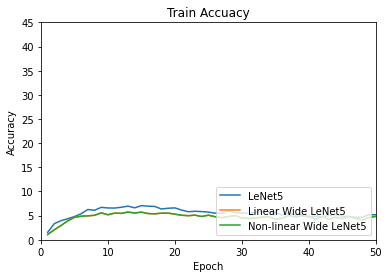

In [ ]:
plt.title('Train Accuacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 45])
plt.plot(epoch, train_deep_acc, label='LeNet5')
plt.plot(epoch, train_LinearWide_acc, label= 'Linear Wide LeNet5')
plt.plot(epoch, train_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'lower right')

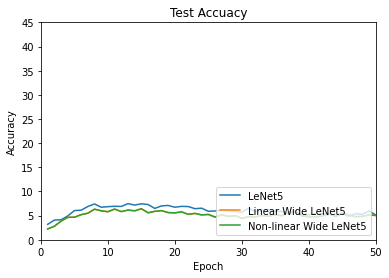

In [ ]:
plt.title('Test Accuacy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 45])
plt.plot(epoch, test_deep_acc, label='LeNet5')
plt.plot(epoch, test_LinearWide_acc, label= 'Linear Wide LeNet5')
plt.plot(epoch, test_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'lower right')

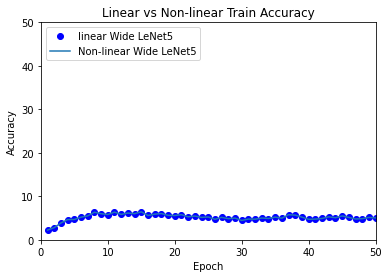

In [ ]:
plt.title('Linear vs Non-linear Train Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 50])
plt.plot(epoch, test_LinearWide_acc, 'bo', label= 'linear Wide LeNet5')
plt.plot(epoch, test_NonLinearWide_acc, label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'upper left')

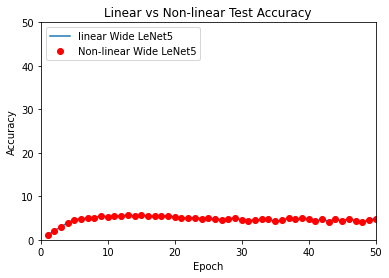

In [ ]:
plt.title('Linear vs Non-linear Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.axis([0, 50, 0, 50])
plt.plot(epoch, train_LinearWide_acc, label= 'linear Wide LeNet5')
plt.plot(epoch, train_NonLinearWide_acc, 'ro', label= 'Non-linear Wide LeNet5')
plt.legend(loc = 'upper left')